In [20]:
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
import gensim
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import models

In [2]:
dfs = pd.read_excel("export.xlsx", sheetname=None)
df = dfs['EAI.TBLEVENT']
all_events_list = "ENVIRONMENTAL_EVENT	PERSONALSAFETY_EVENT	PROCESSSAFETY_EVENT	RELIABILITY_EVENT	SECURITY_EVENT	QUALITY_EVENT	AUDIT_EVENT	ASSESSMENT_EVENT	BEHAVIORTRENDS_EVENT	SUCCESSANALYSIS_EVENT	OTHERLEARNINGEXPERIENCE_EV	OTHERUNPLANNED_EVENT".split("	")
def get_sum_of_cat_per_row(row, event_list):
    sum = 0
    for event in event_list:
        sum += row[event]
    return -sum
df['sum_of_categories'] = df.apply(lambda row: get_sum_of_cat_per_row(row, all_events_list), axis=1)
df = df.loc[df['sum_of_categories'] == 1]
df = df.sample(frac=1)

(array([ 16268.,   5422.,   2536.,   1247.,    767.,    492.,    341.,
           209.,    154.,    109.]),
 array([   0. ,   36.4,   72.8,  109.2,  145.6,  182. ,  218.4,  254.8,
         291.2,  327.6,  364. ]),
 <a list of 10 Patch objects>)

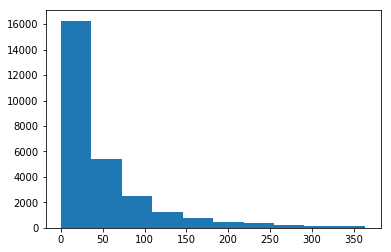

In [3]:
df['desc_len'] = df.apply(lambda row: len(str(row['DESCRIPTION']).split()), axis=1)
plt.hist(df['desc_len'])

In [ ]:
X_all = df['DESCRIPTION'].values.astype('U')
Y_all = -df.loc[:, all_events_list].values
Y_all_indices = [ np.where(r==1)[0][0] for r in Y_all ]
print(X_all[0:2])
print(Y_all[0:2])
print(Y_all_indices[0:2])

In [13]:
train_data_ratio = 0.7
split_index = int(train_data_ratio * len(X_all))
X_train, Y_train_indices, X_test, Y_test_indices = X_all[0:split_index], Y_all_indices[0:split_index], X_all[split_index:], Y_all_indices[split_index:]

In [15]:
tagged_docs = []
for i in range(len(X_train)):
    str_list = X_train[i].split()
    tagged_doc = TaggedDocument(str_list,[Y_train_indices[i]])
    tagged_docs.append(tagged_doc)

In [28]:
# model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1)
# model.build_vocab(tagged_docs)
# for epoch in range(10):
#     model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
#     model.alpha -= 0.002  # decrease the learning rate`
#     model.min_alpha = model.alpha  # fix the learning rate, no decay

model = models.Doc2Vec(tagged_docs, size=50, window=8, min_count=1, workers=4)
model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:359: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [29]:
X_train_vec = [model.infer_vector(instance) for instance in X_train]

In [30]:
clf = LinearSVC(penalty="l1", dual=False, tol=1e-3)
clf.fit(X_train_vec, Y_train_indices)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

In [31]:
print(metrics.accuracy_score(Y_train_indices, clf.predict(X_train_vec)))

0.56330065868


In [32]:
X_test_vec = [model.infer_vector(instance) for instance in X_test]
print(metrics.accuracy_score(Y_test_indices, clf.predict(X_test_vec)))

0.557357212004
